# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

## Install `tsfm`
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [1]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-0srtpd1q/granite-tsfm_15a8cfcbe1dc43318b93c74dc7fe9996
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-0srtpd1q/granite-tsfm_15a8cfcbe1dc43318b93c74dc7fe9996
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip uninstall -y numpy
!pip install numpy==1.26.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [2]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "/content/Macro_with_stocks.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_csv('/content/Macro_with_stocks.csv')
df.head()

,Unnamed: 0,Date_x,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock,...,Volume_Change,DateOnly_x,Month,Date_y,Interest Rate (Federal Funds),Unemployment Rate,Consumer Price Index (CPI),GDP Growth (Real GDP % Change),Inflation (PCE Index),DateOnly_y
0,0,2015-01-02 00:00:00-05:00,37.843589,37.963058,37.099214,37.273823,1529200,0.1,0.0,A,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01
1,2603,2015-01-02 00:00:00-05:00,51.430489,51.733690,50.284011,51.079914,10748600,0.0,0.0,AAL,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01
2,5206,2015-01-02 00:00:00-05:00,24.778677,24.789800,23.879980,24.320431,212818400,0.0,0.0,AAPL,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01
3,7809,2015-01-02 00:00:00-05:00,2.670000,2.670000,2.670000,2.670000,0,0.0,0.0,AMD,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01
4,10412,2015-01-02 00:00:00-05:00,78.145002,78.736054,77.940102,78.546913,1462700,0.0,0.0,AMT,...,NaN,2015-01-02,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01


In [6]:
df['Stock_encoded'], uniques = pd.factorize(df['Stock'])
unique_encoded_values = df['Stock_encoded'].unique().tolist()

In [16]:
df['Stock_encoded']

,Stock_encoded
0,0
1,1
2,2
3,3
4,4
...,...
58893,18
58894,19
58895,20
58896,21


In [7]:
print(unique_encoded_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [9]:
print(df.columns.tolist())

['Unnamed: 0', 'Date_x', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Stock', 'Daily_Return', 'Price_Range', 'Volatility', 'Close_Lag1', 'Open_Lag1', 'Volume_Change', 'DateOnly_x', 'Month', 'Date_y', 'Interest Rate (Federal Funds)', 'Unemployment Rate', 'Consumer Price Index (CPI)', 'GDP Growth (Real GDP % Change)', 'Inflation (PCE Index)', 'DateOnly_y', 'Stock_encoded']


In [35]:
# Drop rows with any NaNs (safe if you have a lot of data)
df.dropna(inplace=True)


In [42]:
df.to_csv('Macro_with_stocks.csv', index=False)

# Data processing

In [43]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "/content/Macro_with_stocks.csv"
timestamp_column = "DateOnly_x"
id_columns = ["Stock_encoded"]  # mention the ids that uniquely identify a time-series.

target_columns = ["Close"]
split_config = {
    "train": [0.0, 0.6],
    "valid": [0.6, 0.8],
    "test": [0.8, 1.0],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [ 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'Daily_Return', 'Price_Range', 'Volatility', 'Close_Lag1', 'Open_Lag1', 'Volume_Change','Interest Rate (Federal Funds)', 'Unemployment Rate', 'Consumer Price Index (CPI)', 'GDP Growth (Real GDP % Change)', 'Inflation (PCE Index)'],
}

## Zero-shot evaluation method

In [44]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

In [24]:
required_length = CONTEXT_LENGTH + PREDICTION_LENGTH
counts = df['Stock_encoded'].value_counts()
too_short = counts[counts < required_length]

print(f"Number of short series: {len(too_short)}")
print("Example of short series lengths:", too_short.head())

Number of short series: 0
Example of short series lengths: Series([], Name: count, dtype: int64)


In [25]:
series_lengths = df.groupby('Stock_encoded').size()
print(series_lengths)

# Optional summary
print("\nSummary statistics:")
print(series_lengths.describe())

Stock_encoded
0     2603
1     2603
2     2603
3     2603
4     2603
5     2603
6     2603
7     2603
8     2603
9     2603
10    2603
11    1632
12    2603
13    2603
14    2603
15    2603
16    2603
17    2603
18    2603
19    2603
20    2603
21    2603
22    2603
dtype: int64

Summary statistics:
count      23.000000
mean     2560.782609
std       202.467496
min      1632.000000
25%      2603.000000
50%      2603.000000
75%      2603.000000
max      2603.000000
dtype: float64


In [40]:
import numpy as np

# Check for infinity
print("Inf counts per column:")
print(np.isinf(df.select_dtypes(include=[np.number])).sum())

# Check for NaNs
print("\nNaN counts per column:")
print(df.isna().sum())

Inf counts per column:
Unnamed: 0                        0
Open                              0
High                              0
Low                               0
Close                             0
Volume                            0
Dividends                         0
Stock Splits                      0
Daily_Return                      0
Price_Range                       0
Volatility                        0
Close_Lag1                        0
Open_Lag1                         0
Volume_Change                     1
Interest Rate (Federal Funds)     0
Unemployment Rate                 0
Consumer Price Index (CPI)        0
GDP Growth (Real GDP % Change)    0
Inflation (PCE Index)             0
Stock_encoded                     0
dtype: int64

NaN counts per column:
Unnamed: 0                        0
Date_x                            0
Open                              0
High                              0
Low                               0
Close                             0
Volu

In [41]:
import numpy as np

# Replace inf with NaN in Volume_Change
df['Volume_Change'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop the row that has the NaN now
df.dropna(subset=['Volume_Change'], inplace=True)

# Double-check
assert not df['Volume_Change'].isna().any(), "Still contains NaN"
assert not np.isinf(df['Volume_Change']).any(), "Still contains inf"


# Zeroshot

INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.7711182832717896, 'eval_model_preparation_time': 0.004, 'eval_runtime': 132.7983, 'eval_samples_per_second': 70.46, 'eval_steps_per_second': 1.107}
(9357, 96, 18)
(9357, 18, 8, 192)


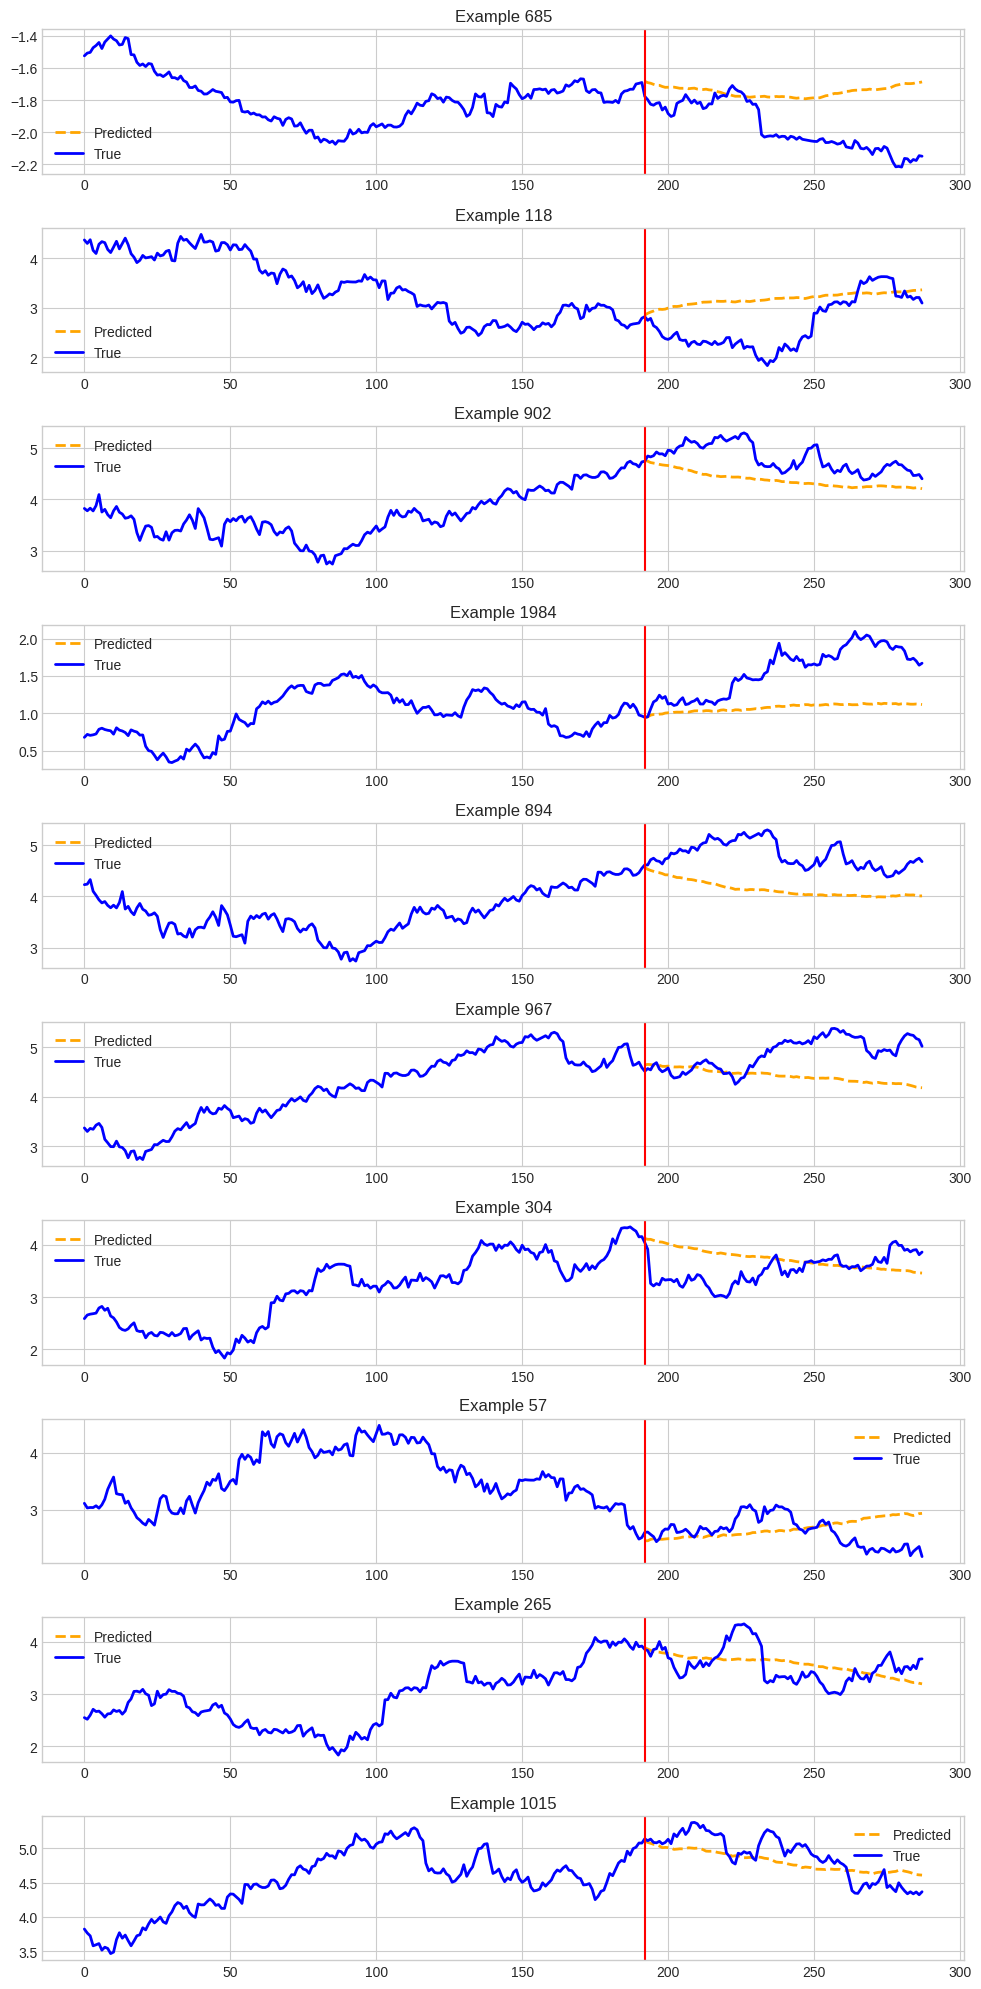

In [45]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

 ## Few-shot finetune and evaluation method

In [ ]:
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer

def delay_transfer_entropy(X, Y, delay=1, k=1, n_bins=10):
    """
    Computes Delay Transfer Entropy from Y to X with delay.

    Parameters:
    - X: array-like, target variable (e.g. stock return)
    - Y: array-like, source variable (e.g. interest rate)
    - delay: int, time delay between Y and X
    - k: int, number of past time steps to use (history length)
    - n_bins: int, number of bins for discretization

    Returns:
    - DTE value (float)
    """
    assert len(X) == len(Y), "X and Y must be same length"
    n = len(X)

    indices = np.arange(k + delay, n)

    # Build history vectors
    X_past = np.stack([X[i - k - delay:i - delay] for i in indices])
    Y_past = np.stack([Y[i - k:i] for i in indices])
    X_now = X[indices]

    # Discretize using equal-width binning
    enc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    X_past_disc = enc.fit_transform(X_past)
    Y_past_disc = enc.fit_transform(Y_past)
    X_now_disc = enc.fit_transform(X_now.reshape(-1, 1)).flatten()

    # Format histories as string keys for entropy estimation
    def to_str(data):
        return ['_'.join(map(str, row.astype(int))) for row in data]

    x_past = to_str(X_past_disc)
    y_past = to_str(Y_past_disc)
    xy_past = [f"{xp}|{yp}" for xp, yp in zip(x_past, y_past)]
    x_now = X_now_disc.astype(int).astype(str)

    # Calculate Transfer Entropy
    H_x_given_xpast = conditional_entropy(x_now, x_past)
    H_x_given_xy = conditional_entropy(x_now, xy_past)

    return H_x_given_xpast - H_x_given_xy

def conditional_entropy(x, cond):
    """
    Conditional entropy H(X | Y) = H(X, Y) - H(Y)
    """
    joint = [f"{xi}|{yi}" for xi, yi in zip(x, cond)]
    return entropy(joint) - entropy(cond)

def entropy(data):
    """
    Compute Shannon entropy of a list of symbols.
    """
    _, counts = np.unique(data, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-9))


### Few-shot 5%

In [ ]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.442100,0.775728
2,0.440500,0.775884
3,0.405500,0.776145
4,0.421700,0.776001
5,0.397500,0.775799
6,0.431200,0.775737
7,0.400600,0.775547
8,0.388100,0.775533
9,0.358600,0.776146
10,0.353500,0.776911


# Fewshot with quantile loss (We can use pinball loss to generate different quantiles as required)

INFO:p-193553:t-23248377201408:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-193553:t-23248377201408:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-193553:t-23248377201408:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.327900,0.273010
2,0.324500,0.272937
3,0.317400,0.272860
4,0.311000,0.272869
5,0.309400,0.273278
6,0.305200,0.274445
7,0.297900,0.276200
8,0.291600,0.279156
9,0.288500,0.283543
10,0.286300,0.286393


[TrackingCallback] Mean Epoch Time = 0.561025069310115 seconds, Total Train Time = 17.760613679885864
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.36178672313690186, 'eval_runtime': 0.7961, 'eval_samples_per_second': 3498.122, 'eval_steps_per_second': 55.267, 'epoch': 13.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2785, 96, 7)
(2785, 7, 8, 192)


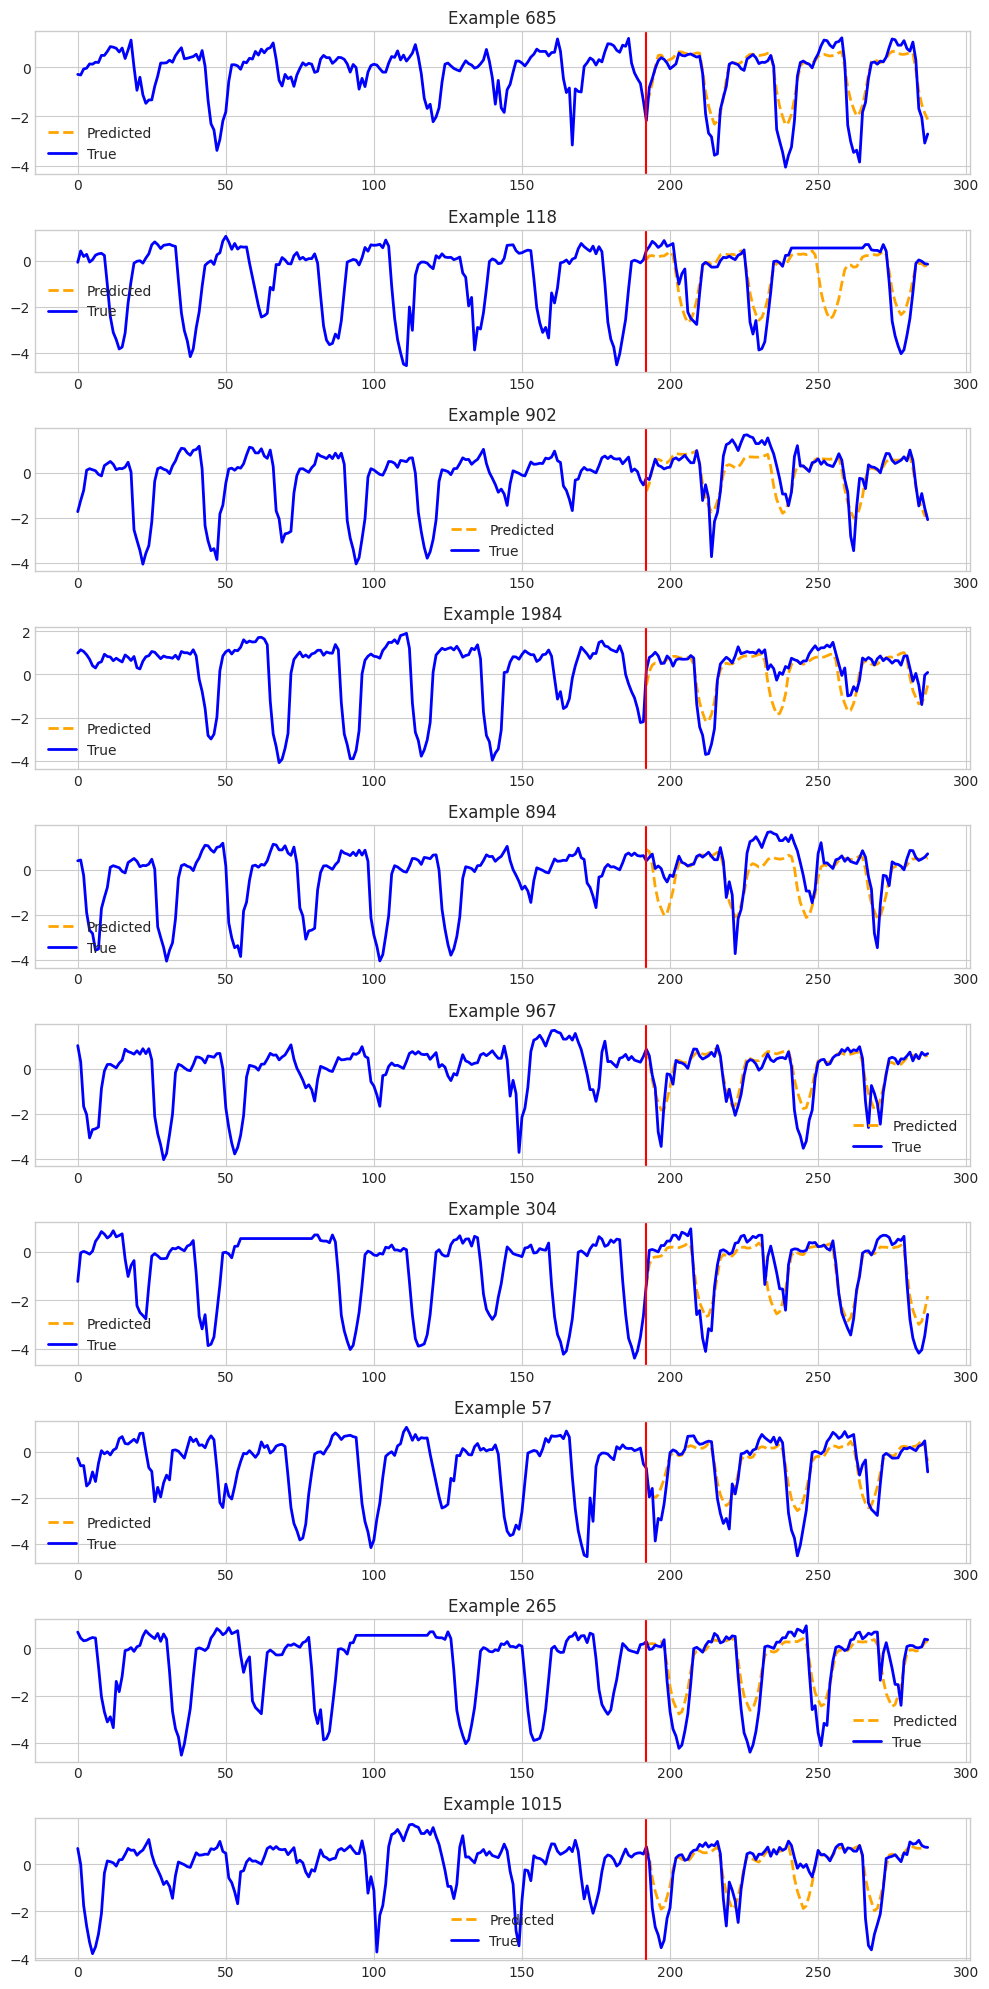

In [ ]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)

## Example: TTM for other forecast horizon lengths and context lengths

The minimum / maximum supported context length for the Granite-TTM-R2 models are 52 and 1536 respectively. Whereas the maximum supported prediction length for Granite-TTM-R2 is 720. (For other models, see the respective model cards)

However, we can ask for a different context length or forecast length, and the `get_model()` utility will choose the closest possible TTM from the model suite. We have to make sure that the required context and prediction lengths are passed to the `TimeSeriesPreprocessor()` so that the data batches are generated correctly. In this notebook, this is handled in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions.

### Zero-shot

INFO:p-193553:t-23248377201408:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-193553:t-23248377201408:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1024-96-r2.
INFO:p-193553:t-23248377201408:get_model.py:get_model:[TTM] context_length = 1024, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.33274462819099426, 'eval_model_preparation_time': 0.0017, 'eval_runtime': 0.899, 'eval_samples_per_second': 3151.371, 'eval_steps_per_second': 50.057}
(2833, 48, 7)
(2833, 7, 8, 384)


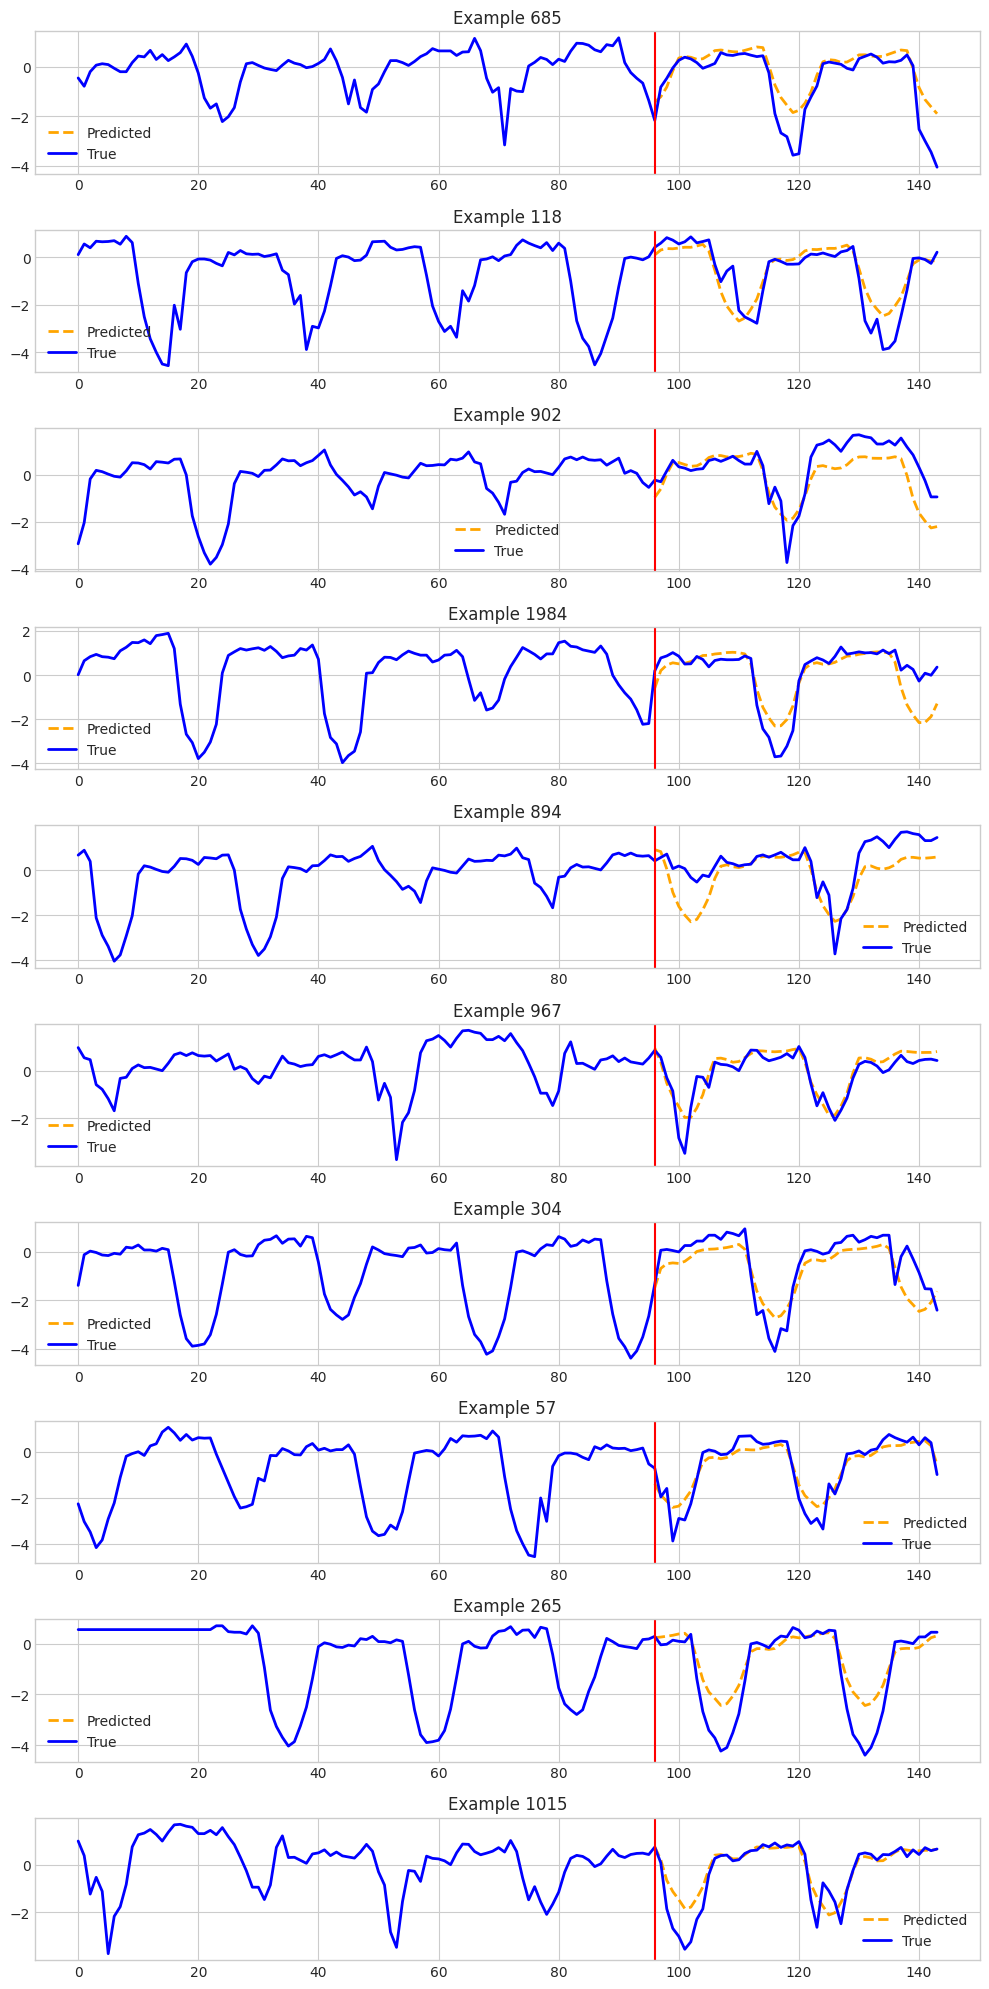

In [ ]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=1024, forecast_length=48, batch_size=64)

### Few-shot 5%

INFO:p-193553:t-23248377201408:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-193553:t-23248377201408:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1536-96-r2.
INFO:p-193553:t-23248377201408:get_model.py:get_model:[TTM] context_length = 1536, prediction_length = 96
INFO:p-193553:t-23248377201408:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-193553:t-23248377201408:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.


-------------------- Running few-shot 5% --------------------
Number of params before freezing backbone 3081120
Number of params after freezing the backbone 1054560


INFO:p-193553:t-23248377201408:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 0.00035938136638046257


OPTIMAL SUGGESTED LEARNING RATE = 0.00035938136638046257
Using learning rate = 0.00035938136638046257


Epoch,Training Loss,Validation Loss
1,0.558300,0.504625
2,0.522800,0.505693
3,0.492200,0.506962
4,0.483700,0.508520
5,0.397600,0.510497
6,0.323300,0.514045
7,0.345200,0.525361
8,0.280800,0.541318
9,0.238600,0.550981
10,0.221500,0.592485


[TrackingCallback] Mean Epoch Time = 0.5700289119373668 seconds, Total Train Time = 17.286776304244995
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.32994186878204346, 'eval_runtime': 0.9431, 'eval_samples_per_second': 3003.961, 'eval_steps_per_second': 47.716, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2833, 48, 7)
(2833, 7, 12, 384)


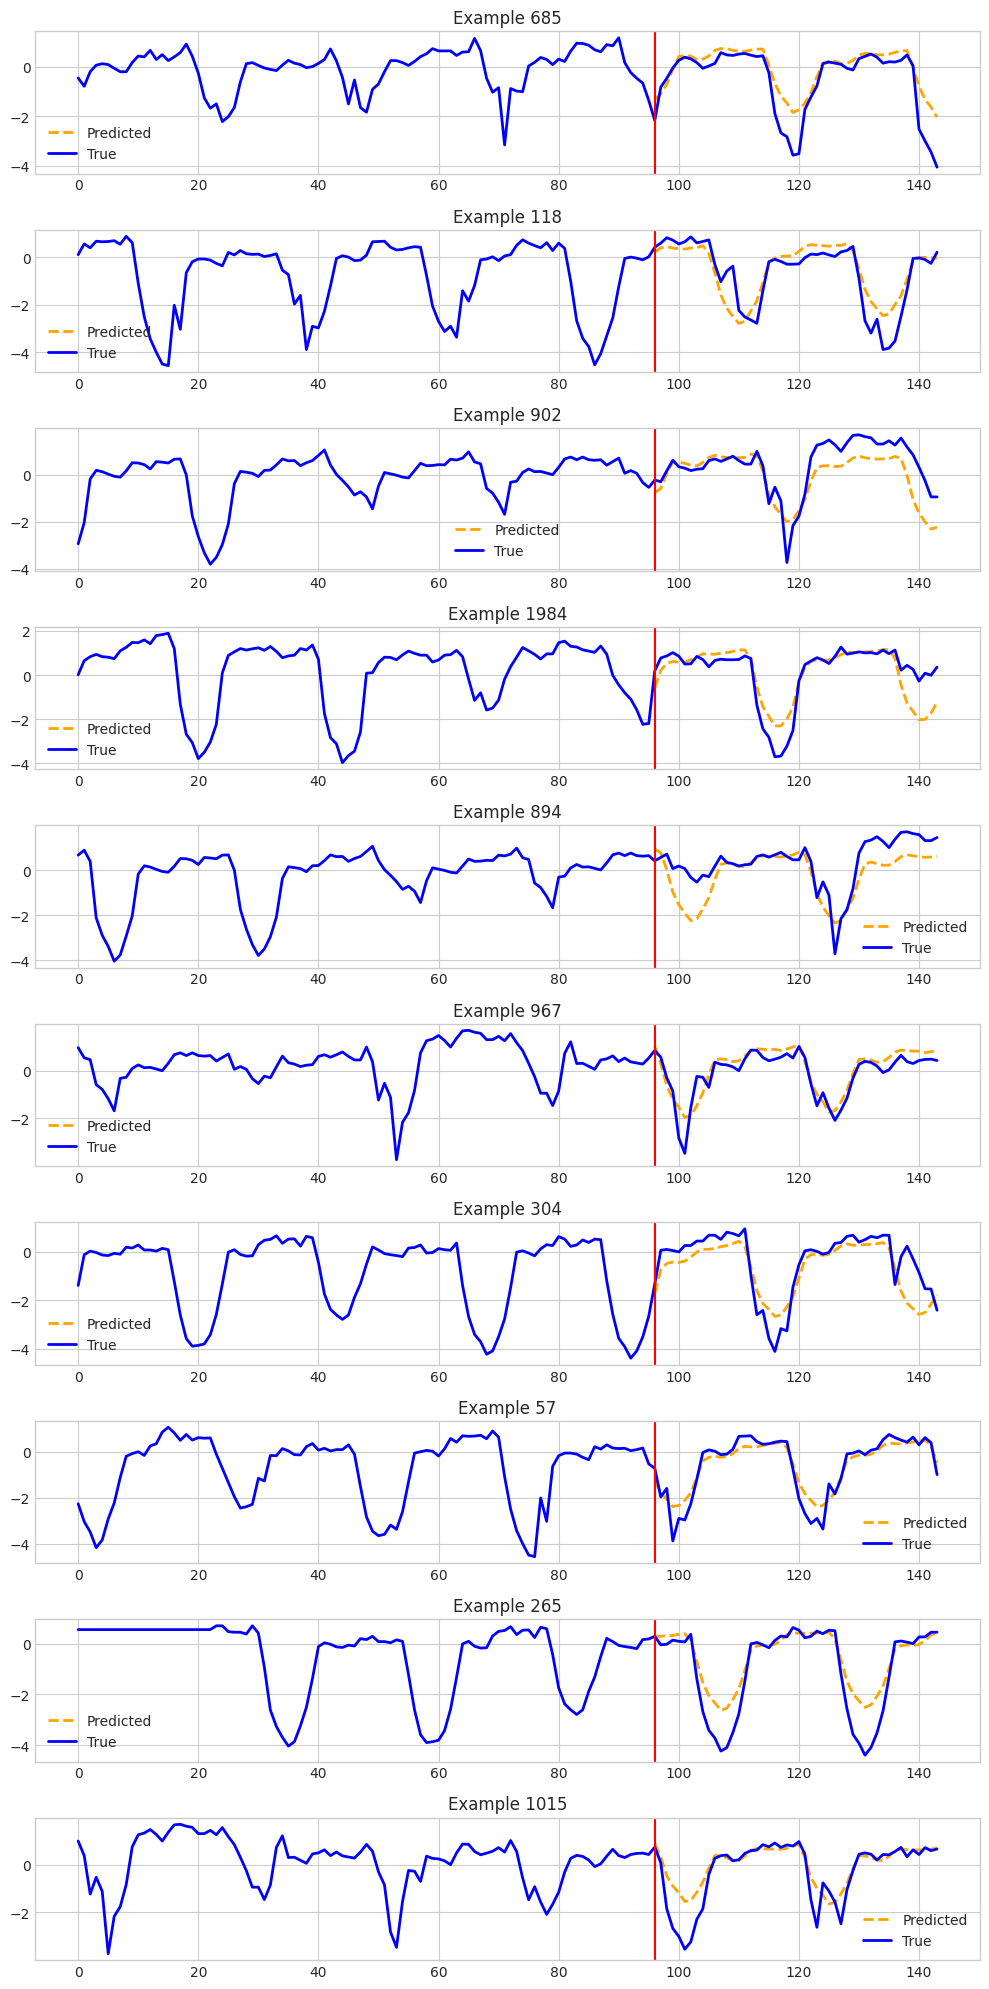

In [ ]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=1536,
    forecast_length=48,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
)